In [26]:
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization, Activation
from  keras.callbacks import ModelCheckpoint
from keras import regularizers, optimizers
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
import torch
import tensorflow as tf
import matplotlib.pyplot as plt

In [3]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

170508288/170498071 [==============================] - 5s 0us/step


In [5]:
torch.cuda.is_available()

True

In [6]:
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

(x_train, x_valid) = x_train[5000:], x_train[:5000]
(y_train, y_valid) = y_train[5000:], y_train[:5000]

In [7]:
print(x_train.shape)
print(x_valid.shape)
print(x_test.shape)

(45000, 32, 32, 3)
(5000, 32, 32, 3)
(10000, 32, 32, 3)


In [8]:
mean = np.mean(x_train, axis = (0,1,2,3))
std = np.std(x_train, axis = (0,1,2,3))

x_train = (x_train - mean) / (std )
x_valid = (x_valid - mean) / (std) 
x_test = (x_test - mean) / (std)

In [9]:
num_classes = 10

y_train = to_categorical(y_train, num_classes)
y_valid = to_categorical(y_valid, num_classes)
y_test = to_categorical(y_test, num_classes)

In [10]:
datagen = ImageDataGenerator(
        rotation_range = 15,
        width_shift_range = 0.1,
        height_shift_range = 0.1,
        horizontal_flip = True,
        vertical_flip = False
)

datagen.fit(x_train)

In [11]:
base_hidden_units = 32
weight_decay = 1e-4
INPUT_SHAPE = x_train.shape[1:]
model = Sequential()

model.add(Conv2D(base_hidden_units, kernel_size = 3, padding = 'same', 
                 kernel_regularizer = regularizers.l2(weight_decay), input_shape = INPUT_SHAPE))
model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(Conv2D(base_hidden_units, kernel_size = 3, padding = 'same', 
                 kernel_regularizer = regularizers.l2(weight_decay), input_shape = INPUT_SHAPE))
model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(base_hidden_units * 2, kernel_size = 3, padding = 'same', 
                 kernel_regularizer = regularizers.l2(weight_decay), input_shape = INPUT_SHAPE))
model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(Conv2D(base_hidden_units * 2, kernel_size = 3, padding = 'same', 
                 kernel_regularizer = regularizers.l2(weight_decay), input_shape = INPUT_SHAPE))
model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(base_hidden_units * 4, kernel_size = 3, padding = 'same', 
                 kernel_regularizer = regularizers.l2(weight_decay), input_shape = INPUT_SHAPE))
model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(Conv2D(base_hidden_units * 4, kernel_size = 3, padding = 'same', 
                 kernel_regularizer = regularizers.l2(weight_decay), input_shape = INPUT_SHAPE))
model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(0.4))

model.add(Flatten())
model.add(Dense(10, activation = 'softmax'))

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 activation (Activation)     (None, 32, 32, 32)        0         
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 activation_1 (Activation)   (None, 32, 32, 32)        0         
                                                                 
 batch_normalization_1 (Batc  (None, 32, 32, 32)       128       
 hNormalization)                                        

In [24]:
batch_size = 128

epochs = 50

checkpointer = ModelCheckpoint(filepath = 'model.weights.best.hdf5', verbose =1, save_best_only = True)

optimizer = tf.keras.optimizers.Adam(lr = 0.0001, decay = 1e-6)

model.compile(loss = 'categorical_crossentropy', optimizer = optimizer, metrics = ['accuracy'])

history = model.fit_generator(datagen.flow(x_train, y_train, batch_size = batch_size), callbacks = [checkpointer],steps_per_epoch = x_train.shape[0] // batch_size, epochs = epochs,
                              verbose = 2, validation_data = (x_valid, y_valid))

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  if sys.path[0] == '':


Epoch 1/50

Epoch 1: val_loss improved from inf to 1.96498, saving model to model.weights.best.hdf5
351/351 - 34s - loss: 2.7832 - accuracy: 0.2630 - val_loss: 1.9650 - val_accuracy: 0.2890 - 34s/epoch - 98ms/step
Epoch 2/50

Epoch 2: val_loss improved from 1.96498 to 1.52090, saving model to model.weights.best.hdf5
351/351 - 20s - loss: 2.1009 - accuracy: 0.3457 - val_loss: 1.5209 - val_accuracy: 0.4732 - 20s/epoch - 56ms/step
Epoch 3/50

Epoch 3: val_loss improved from 1.52090 to 1.49518, saving model to model.weights.best.hdf5
351/351 - 20s - loss: 1.8718 - accuracy: 0.3936 - val_loss: 1.4952 - val_accuracy: 0.4776 - 20s/epoch - 56ms/step
Epoch 4/50

Epoch 4: val_loss improved from 1.49518 to 1.45513, saving model to model.weights.best.hdf5
351/351 - 20s - loss: 1.7297 - accuracy: 0.4389 - val_loss: 1.4551 - val_accuracy: 0.4886 - 20s/epoch - 56ms/step
Epoch 5/50

Epoch 5: val_loss did not improve from 1.45513
351/351 - 20s - loss: 1.6119 - accuracy: 0.4696 - val_loss: 1.5271 - val_

In [25]:
scores = model.evaluate(x_test, y_test, batch_size = 128, verbose = 1)
print('Test result : ', scores[1] * 100, 'loss : ', scores[0])


79/79 [==============================] - 1s 7ms/step - loss: 0.7139 - accuracy: 0.7788
Test result :  77.88000106811523 loss :  0.7138845920562744


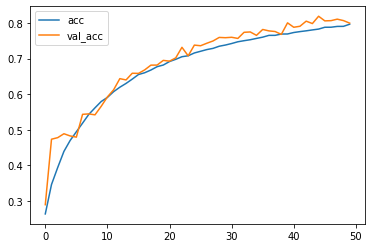

In [32]:
plt.plot(history.history['accuracy'], label = 'acc')
plt.plot(history.history['val_accuracy'], label = 'val_acc')
plt.legend()